In [40]:
import numpy as np
import glob
import matplotlib.pyplot as plt
import cv2
from skimage import measure, segmentation
from vis_utils import load_volume, VolumeVisualizer
from scipy.ndimage import zoom
from skimage.morphology import skeletonize, skeletonize_3d
from skimage import filters, morphology

from scipy.ndimage.filters import convolve, correlate
from scipy import signal

In [2]:
source_dir = './data/'
files = list(sorted(glob.glob(source_dir + '/*/*.raw')))
list(enumerate(files))

[(0, './data/P01/P01_60um_1612x623x1108.raw'),
 (1, './data/P02/P02_60um_1387x778x1149.raw'),
 (2, './data/P03/P03_60um_1473x1163x1148.raw'),
 (3, './data/P04/P04_60um_1273x466x1045.raw'),
 (4, './data/P05/P05_60um_1454x817x1102.raw'),
 (5, './data/P06/P06_60um_1425x564x1028.raw'),
 (6, './data/P07/P7_60um_1216x692x926.raw'),
 (7, './data/P08/P08_60um_1728x927x1149.raw'),
 (8, './data/P09/P09_60um_1359x456x1040.raw'),
 (9, './data/P10/P10_60um_1339x537x1035.raw'),
 (10, './data/P11/P11_60um_1735x595x1150.raw'),
 (11, './data/P12/P12_60um_1333x443x864.raw'),
 (12, './data/P13/P13_60um_1132x488x877.raw'),
 (13, './data/P14/P14_60um_1927x746x1124.raw'),
 (14, './data/P15/P15_60um_1318x640x1059.raw'),
 (15, './data/P16/P16_60um_1558x687x1084.raw'),
 (16, './data/P17/P17_60um_1573x555x968.raw'),
 (17, './data/P320/320_60um_1739x553x960.raw'),
 (18, './data/P333/333_60um_1762x989x1095.raw'),
 (19, './data/P73/73_60um_1729x854x1143.raw')]

In [3]:
%%time
volume = load_volume(files[11], scale=0.5)
print(volume.shape, volume.size)

(432, 222, 666) 63872064
CPU times: user 1.26 s, sys: 508 ms, total: 1.77 s
Wall time: 1.8 s


In [4]:
visualizer = VolumeVisualizer(volume, binary=False).visualize()

## simple threshold segmentation

In [5]:
threshold = 70
mask = volume > threshold

VolumeVisualizer(mask).visualize()

## histeresis threshold

In [26]:
high_th = 60
low_th = 50

mask = apply_hysteresis_threshold(volume, low=low_th, high=high_th)

VolumeVisualizer(mask).visualize()

In [6]:
def get_main_regions(binary_mask, min_size=10_000, connectivity=3):
    labeled = measure.label(binary_mask, connectivity=connectivity)
    region_props = measure.regionprops(labeled)
    
    main_regions_masks = []
    
    for props in region_props:
        if props.area >= min_size:
            main_regions_masks.append((props.filled_image, props.bbox))
            
    return main_regions_masks

def merge_masks(masks, img_shape):
    result_mask = np.zeros(img_shape, dtype=np.uint8)
    for mask, bbox in masks:
        min1, min2, min3, max1, max2, max3 = bbox
        result_mask[min1:max1, min2:max2, min3:max3] += mask.astype(np.uint8)
        
    return result_mask

In [7]:
%%time
main_regions_masks = get_main_regions(mask, min_size=5_000, connectivity=1)
len(main_regions_masks)

CPU times: user 11.6 s, sys: 585 ms, total: 12.2 s
Wall time: 12.2 s


1

In [34]:
VolumeVisualizer(
    main_regions_masks[0][0], binary=False
).visualize(scale=1, primary_color=(255,255,255))

In [5]:
merged_mask = merge_masks(main_regions_masks, binary_mask.shape)
merged_mask[50:180, 50:160, 70:200] = 0.5

visualizer = VolumeVisualizer(
    merged_mask * 100
).visualize(scale=1, primary_color=(255,255,255))

NameError: name 'merge_masks' is not defined

In [8]:
main_regions_masks[0][0].max()

True

In [9]:
main_mask = main_regions_masks[0][0]

## generating spherical kernel

In [61]:
def spherical_kernel(outer_radius, thickness=1):
   
    inner_radius = outer_radius - thickness
    
    outer_sphere = morphology.ball(radius=outer_radius)
    inner_sphere = morphology.ball(radius=inner_radius)
    
    begin = outer_radius - inner_radius
    end = begin + inner_sphere.shape[0]
    
    outer_sphere[begin:end, begin:end, begin:end] -= inner_sphere
    return outer_sphere

In [26]:
kernel = spherical_kernel(outer_radius=20)
VolumeVisualizer(kernel[:20], binary=False).visualize(primary_color=(255,255,255))

In [30]:
conv = convolution.convolve(kernel, kernel, normalize_kernel=False)

In [32]:
conv.max()

(4730.0, 4730)

## convolving with 3d kernel

In [62]:
# (432, 222, 666)
kernel_radius = 15
kernel = spherical_kernel(kernel_radius, 4)
kernel_size = kernel.shape[0]

print(kernel.sum(), kernel.shape)

mask_slice = main_mask.copy()
# mask_slice[:kernel_size, :kernel_size, :kernel_size] = kernel
# VolumeVisualizer(mask_slice).visualize()

8572 (31, 31, 31)


In [63]:
%%time

convolved = signal.convolve(mask_slice.astype(np.uint16), kernel.astype(np.uint16), mode='valid')
print(convolved.shape, convolved.max())

(381, 166, 615) 4016
CPU times: user 7.05 s, sys: 4.58 s, total: 11.6 s
Wall time: 12.1 s


In [64]:
VolumeVisualizer((convolved / convolved.max() * 255).astype(np.uint8), binary=False
                ).visualize(primary_color=(255,255,255))

In [161]:
np.unique(kernel_conv, return_counts=True)

(array([0, 1, 2, 6], dtype=uint8), array([106,   6,  12,   1]))

In [14]:
def disk_kernel(outer_radius, inner_radius='auto'):
    
    if inner_radius == 'auto':
        inner_radius = outer_radius - 1
    
    outer_sphere = morphology.disk(radius=outer_radius)
    inner_sphere = morphology.disk(radius=inner_radius)
    
    begin = outer_radius - inner_radius
    end = begin + inner_sphere.shape[0]
    
    outer_sphere[begin:end, begin:end] -= inner_sphere
    return outer_sphere

253 1.0


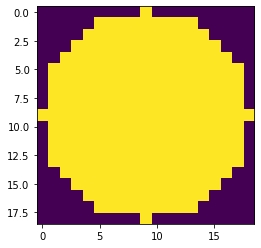

In [16]:
kernel = morphology.disk(radius=9)
conv = convolution.convolve(kernel.copy(), kernel.copy())
print(kernel.sum(), conv.max())
plt.imshow(kernel)

377 0.5305039787798409


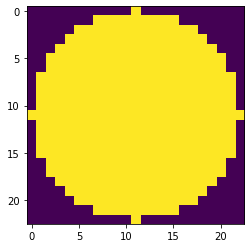

In [24]:
kernel = morphology.disk(radius=11)
kernel2 = kernel.copy()
kernel2[:11] = 0
conv = convolution.convolve(kernel2, kernel)
print(kernel.sum(), conv.max())
plt.imshow(kernel)

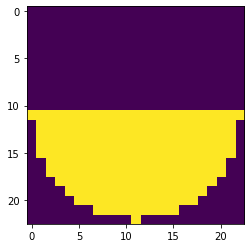

In [23]:
plt.imshow(kernel2)

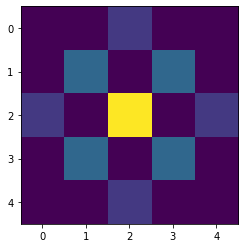

In [120]:
plt.imshow(kernel_conv[2])

In [122]:
kernel_conv.max(), kernel.sum()

(6, 6)

In [91]:
cube1 = np.ones((3, 3, 3))
# cube1[1, 1, 1] = 0
cube2 = np.ones((3, 3, 3))
signal.convolve(cube1, cube2, mode='valid')

array([[[27.]]])

In [74]:
arr = np.array([
    [1, 2, 3],
    [4, 5, 6],
    [7, 8, 9]
])

ker = np.array([
    [1, 1],
    [1, 1]
])

signal.convolve(arr, ker, mode='valid')

array([[12, 16],
       [24, 28]])